# SCENIC Protocol - Case study - Mouse brain data set


__Author:__ Bram Van de Sande

__Date:__ 6 AUG 2019

__Outline:__ Acquistion and cleaning of selected scRNAseq data sets.

_Experiments:_

| Accession ID | Cancer type | 
| ------------- | ----------- | 
| GSE60361 | Mouse brain |

In [1]:
import os, glob, re, pickle
from functools import partial
from collections import OrderedDict
import operator as op
from cytoolz import compose

import pandas as pd
import seaborn as sns
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt

from pyscenic.export import export2loom, add_scenic_metadata
from pyscenic.utils import load_motifs
from pyscenic.transform import df2regulons
from pyscenic.aucell import aucell
from pyscenic.binarization import binarize
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_binarization, plot_rss

/Users/bramvandesande/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
# Set maximum number of jobs
sc.settings.njobs = 32

In [3]:
RESOURCES_FOLDERNAME = "/Users/bramvandesande/Projects/lcb/protocol/resources/"
RESULTS_FOLDERNAME = "/Users/bramvandesande/Projects/lcb/protocol/results/"
FIGURES_FOLDERNAME = "/Users/bramvandesande/Projects/lcb/protocol/figures/"
AUXILLIARIES_FOLDERNAME = "/Users/bramvandesande/Projects/lcb/protocol/auxilliaries/"

In [4]:
# Ranking databases. Downloaded from cisTargetDB: https://resources.aertslab.org/cistarget/
RANKING_DBS_FNAMES = list(map(lambda fn: os.path.join(AUXILLIARIES_FOLDERNAME, fn),
                       ['mm9-500bp-upstream-10species.mc9nr.feather',
                       'mm9-tss-centered-10kb-10species.mc9nr.feather',
                        'mm9-tss-centered-5kb-10species.mc9nr.feather']))
# Motif annotations. Downloaded from cisTargetDB: https://resources.aertslab.org/cistarget/
MOTIF_ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDERNAME, 'motifs-v9-nr.mgi-m0.001-o0.0.tbl')

__CLEANING METADATA AND QC__

In [5]:
DATASET_ID = 'GSE60361'

In [6]:
# Downloaded expression matrix from GEO on 13 JUN 2019 (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE60361).
COUNTS_MTX_FNAME = os.path.join(RESOURCES_FOLDERNAME, 'GSE60361_C1-3005-Expression.txt')
# Downloaded metadata from http://linnarssonlab.org/cortex/ on 13 JUN 2019
METADATA_FNAME = os.path.join(RESOURCES_FOLDERNAME, 'expression_mRNA_17-Aug-2014.txt')

MM_TFS_FNAME = os.path.join(RESULTS_FOLDERNAME, 'mm_tfs.txt')

# Output file
COUNTS_QC_MTX_FNAME = os.path.join(RESULTS_FOLDERNAME, 'GSE60361.qc.counts.csv')
ADJACENCIES_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.adjacencies.tsv'.format(DATASET_ID))
MOTIFS_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.motifs.csv'.format(DATASET_ID))
REGULONS_DAT_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.regulons.dat'.format(DATASET_ID))
AUCELL_MTX_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.auc.csv'.format(DATASET_ID))
BIN_MTX_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.bin.csv'.format(DATASET_ID))
THR_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.thresholds.csv'.format(DATASET_ID))
ANNDATA_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.h5ad'.format(DATASET_ID))
LOOM_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.loom'.format(DATASET_ID))

In [7]:
#Create list of M. musculus transcription factors.
pd_motifs = pd.read_csv(MOTIF_ANNOTATIONS_FNAME, sep='\t')

/Users/bramvandesande/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
mm_tfs = pd_motifs.gene_name.unique()
len(mm_tfs)

1721

In [9]:
with open(MM_TFS_FNAME, 'wt') as f:
    f.write('\n'.join(mm_tfs) + '\n')

In [10]:
df_counts = pd.read_csv(COUNTS_MTX_FNAME, sep='\t', index_col=0)
df_counts.shape

(19972, 3005)

In [11]:
df_metadata = pd.read_csv(METADATA_FNAME, sep='\t', index_col=1, nrows=9).drop(columns=['Unnamed: 0']).T.reset_index() #.drop(columns=['index', 'group #'])
df_metadata.columns.name = ''

In [12]:
df_metadata.age = df_metadata.age.astype(int)

In [13]:
df_metadata.head()

index group # total mRNA mol well sex  age diameter         cell_id  \
0    sscortex       1          21580   11   1   21        0  1772071015_C02   
1  sscortex.1       1          21748   95  -1   20     9.56  1772071017_G12   
2  sscortex.2       1          31642   33  -1   20     11.1  1772071017_A05   
3  sscortex.3       1          32916   42   1   21     11.7  1772071014_B06   
4  sscortex.4       1          21531   48   1   25       11  1772067065_H06   

    level1class level2class  
0  interneurons       Int10  
1  interneurons       Int10  
2  interneurons        Int6  
3  interneurons       Int10  
4  interneurons        Int9

In [14]:
adata = sc.AnnData(X=df_counts.T.sort_index())
adata.obs = df_metadata.set_index('cell_id').sort_index()
adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.raw = adata #Store non-log transformed data as raw. This data can be used via the use_raw parameters available for many functions.
df_counts_qc = adata.to_df()
sc.pp.normalize_total(adata, fraction=0.9)
sc.pp.log1p(adata)
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 3005 × 18879 
    obs: 'index', 'group #', 'total mRNA mol', 'well', 'sex', 'age', 'diameter', 'level1class', 'level2class', 'n_genes'
    var: 'n_cells'

In [15]:
df_counts_qc.to_csv(COUNTS_QC_MTX_FNAME)

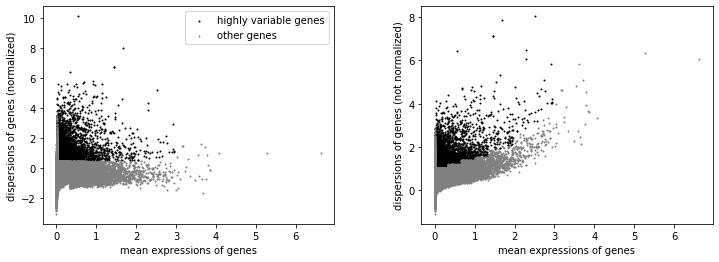

In [16]:
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)

In [17]:
adata = adata[:, adata.var['highly_variable']]

In [18]:
sc.tl.pca(adata, svd_solver='arpack')

Trying to set attribute `.obsm` of view, making a copy.


In [19]:
sc.tl.tsne(adata)

... storing 'group #' as categorical
... storing 'total mRNA mol' as categorical
... storing 'well' as categorical
... storing 'sex' as categorical
... storing 'diameter' as categorical
... storing 'level1class' as categorical
... storing 'level2class' as categorical


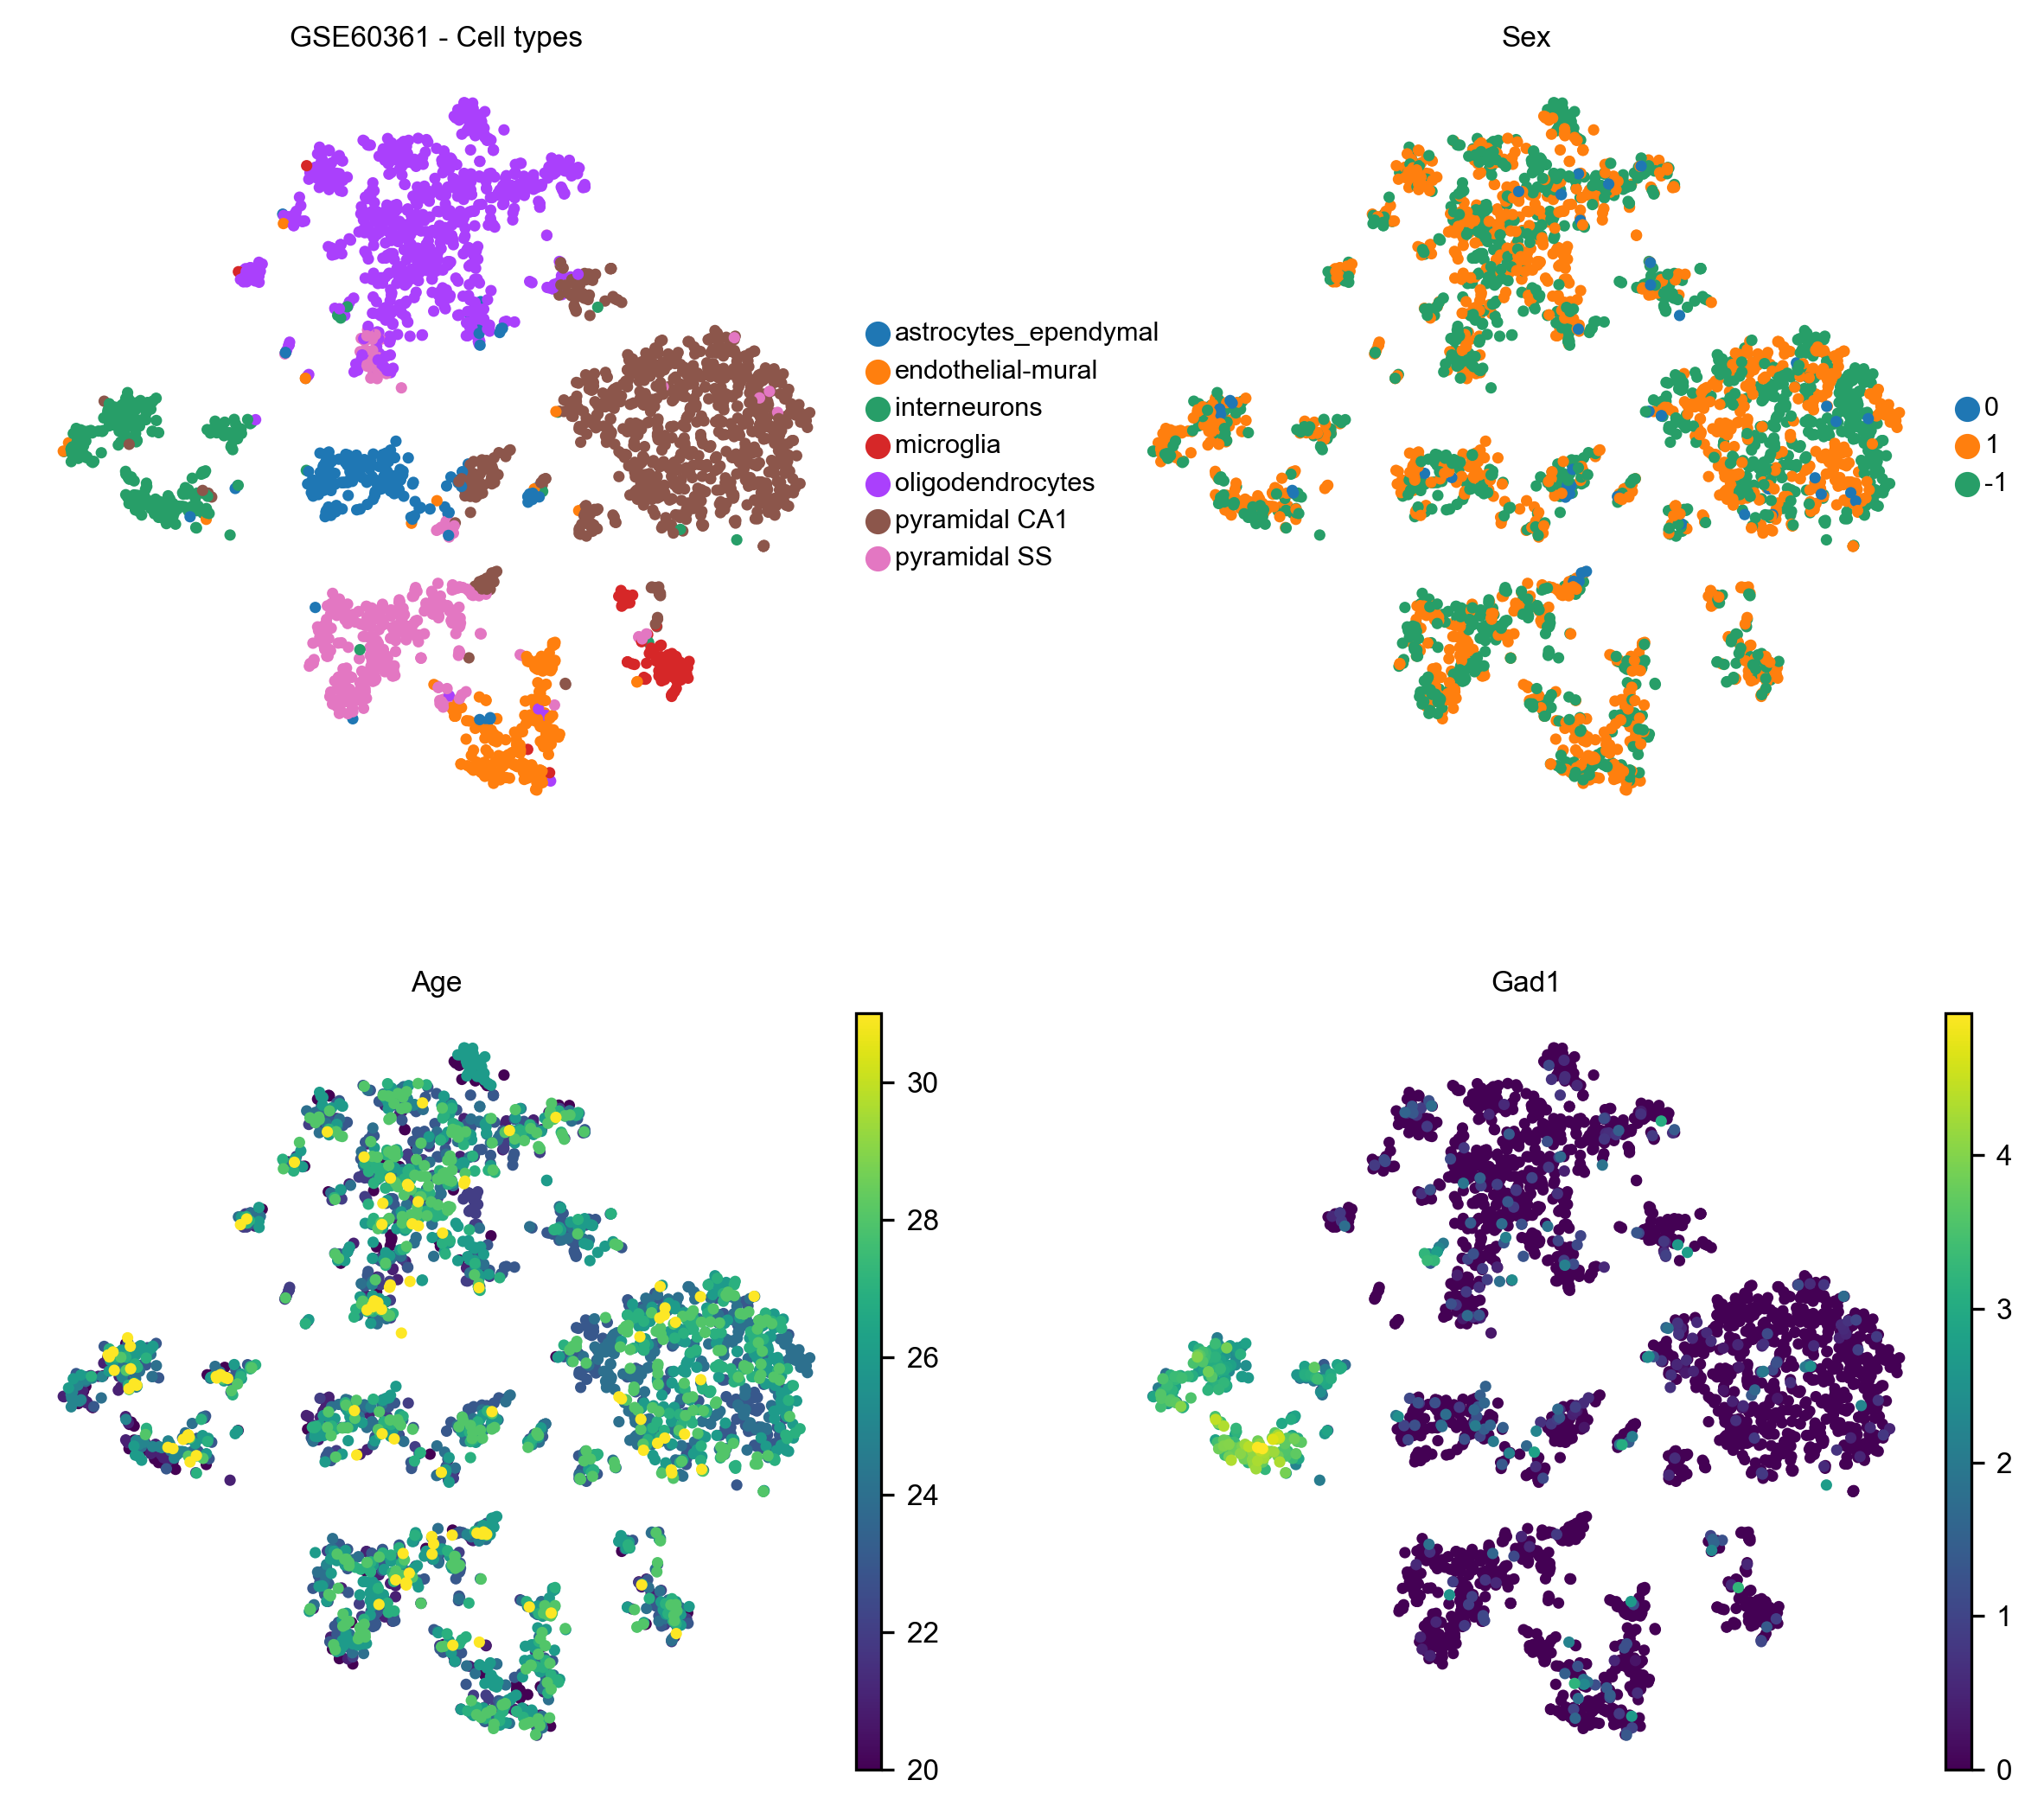

In [20]:
sc.set_figure_params(frameon=False, dpi=150, fontsize=8)
sc.pl.tsne(adata, color=['level1class', 'sex', 'age', 'Gad1' ], 
           title=['GSE60361 - Cell types', 'Sex', 'Age', 'Gad1'], ncols=2, use_raw=False)

### STEP 1: Network inference based on GRNBoost2 from CLI

For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system.

_Output:_ List of adjacencies between a TF and its targets stored in `ADJACENCIES_FNAME`.

```
2019-06-13 17:32:45,044 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.
2019-06-13 17:33:07,766 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
preparing dask client
parsing input
creating dask graph
32 partitions
computing dask graph
not shutting down client, client was created externally
finished
2019-06-13 18:04:23,356 - pyscenic.cli.pyscenic - INFO - Writing results to file.
```

### STEP 2-3: Regulon prediction aka cisTarget from CLI

For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system.

_Output:_ List of adjacencies between a TF and its targets stored in `MOTIFS_FNAME`.

In [21]:
DBS_PARAM = ' '.join(RANKING_DBS_FNAMES)

```
2019-06-14 09:49:42,740 - pyscenic.cli.pyscenic - INFO - Creating modules.
2019-06-14 09:49:45,193 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.
2019-06-14 09:52:42,315 - pyscenic.cli.pyscenic - INFO - Loading databases.
2019-06-14 09:52:42,316 - pyscenic.cli.pyscenic - INFO - Calculating regulons.
2019-06-14 10:18:06,172 - pyscenic.cli.pyscenic - INFO - Writing results to file.
```

In [22]:
df_motifs = load_motifs(MOTIFS_FNAME)

### STEP 4: Cellular enrichment aka AUCell

__REGULON CREATION__

Regulons can easily be created from this list of enriched motifs via `pyscenic.transform.df2regulons`. Here we provide an auxilliary function to carefully select the enriched motifs that contribute to the regulons.

In [23]:
def derive_regulons(motifs, db_names=('mm9-tss-centered-10kb-10species', 
                                 'mm9-500bp-upstream-10species', 
                                 'mm9-tss-centered-5kb-10species')):
    motifs.columns = motifs.columns.droplevel(0)

    def contains(*elems):
        def f(context):
            return any(elem in context for elem in elems)
        return f

    # For the creation of regulons we only keep the 10-species databases and the activating modules. We also remove the
    # enriched motifs for the modules that were created using the method 'weight>50.0%' (because these modules are not part
    # of the default settings of modules_from_adjacencies anymore.
    motifs = motifs[
        np.fromiter(map(compose(op.not_, contains('weight>50.0%')), motifs.Context), dtype=np.bool) & \
        np.fromiter(map(contains(*db_names), motifs.Context), dtype=np.bool) & \
        np.fromiter(map(contains('activating'), motifs.Context), dtype=np.bool)]

    # We build regulons only using enriched motifs with a NES of 3.0 or higher; we take only directly annotated TFs or TF annotated
    # for an orthologous gene into account; and we only keep regulons with at least 10 genes.
    regulons = list(filter(lambda r: len(r) >= 10, df2regulons(motifs[(motifs['NES'] >= 3.0) 
                                                                      & ((motifs['Annotation'] == 'gene is directly annotated')
                                                                        | (motifs['Annotation'].str.startswith('gene is orthologous to')
                                                                           & motifs['Annotation'].str.endswith('which is directly annotated for motif')))
                                                                     ])))
    
    # Rename regulons, i.e. remove suffix.
    return list(map(lambda r: r.rename(r.transcription_factor), regulons))

In [24]:
regulons = derive_regulons(df_motifs)

__AUCELL__

```
CPU times: user 10.5 s, sys: 4.41 s, total: 14.9 s
Wall time: 14 s
```

In [25]:
auc_mtx = pd.read_csv(AUCELL_MTX_FNAME, index_col=0)

__AUCELL + tSNE PROJECTION__

We add all metadata derived from SCENIC to the `scanpy.AnnData` object.

In [26]:
add_scenic_metadata(adata, auc_mtx, regulons)

AnnData object with n_obs × n_vars = 3005 × 4109 
    obs: 'index', 'group #', 'total mRNA mol', 'well', 'sex', 'age', 'diameter', 'level1class', 'level2class', 'n_genes', 'Regulon(2610044O15Rik8)', 'Regulon(Aebp2)', 'Regulon(Ahctf1)', 'Regulon(Ahr)', 'Regulon(Alx1)', 'Regulon(Arnt2)', 'Regulon(Atf2)', 'Regulon(Atf3)', 'Regulon(Atf4)', 'Regulon(Atf5)', 'Regulon(Atf6)', 'Regulon(Atf6b)', 'Regulon(Atf7)', 'Regulon(Atoh1)', 'Regulon(Bcl3)', 'Regulon(Bcl6)', 'Regulon(Bhlhe40)', 'Regulon(Brf1)', 'Regulon(Cdx1)', 'Regulon(Cebpa)', 'Regulon(Cebpb)', 'Regulon(Cebpd)', 'Regulon(Cebpz)', 'Regulon(Chd2)', 'Regulon(Creb5)', 'Regulon(Ctcf)', 'Regulon(Ctcfl)', 'Regulon(Cux1)', 'Regulon(Dbp)', 'Regulon(Deaf1)', 'Regulon(Dlx1)', 'Regulon(Dlx2)', 'Regulon(Dlx5)', 'Regulon(Dlx6)', 'Regulon(E2f1)', 'Regulon(E2f2)', 'Regulon(E2f6)', 'Regulon(E2f7)', 'Regulon(E2f8)', 'Regulon(Ebf1)', 'Regulon(Egr1)', 'Regulon(Egr2)', 'Regulon(Egr3)', 'Regulon(Egr4)', 'Regulon(Elf1)', 'Regulon(Elf4)', 'Regulon(Elf5)', 'Regu

In [27]:
sc.tl.tsne(adata, use_rep='X_aucell')

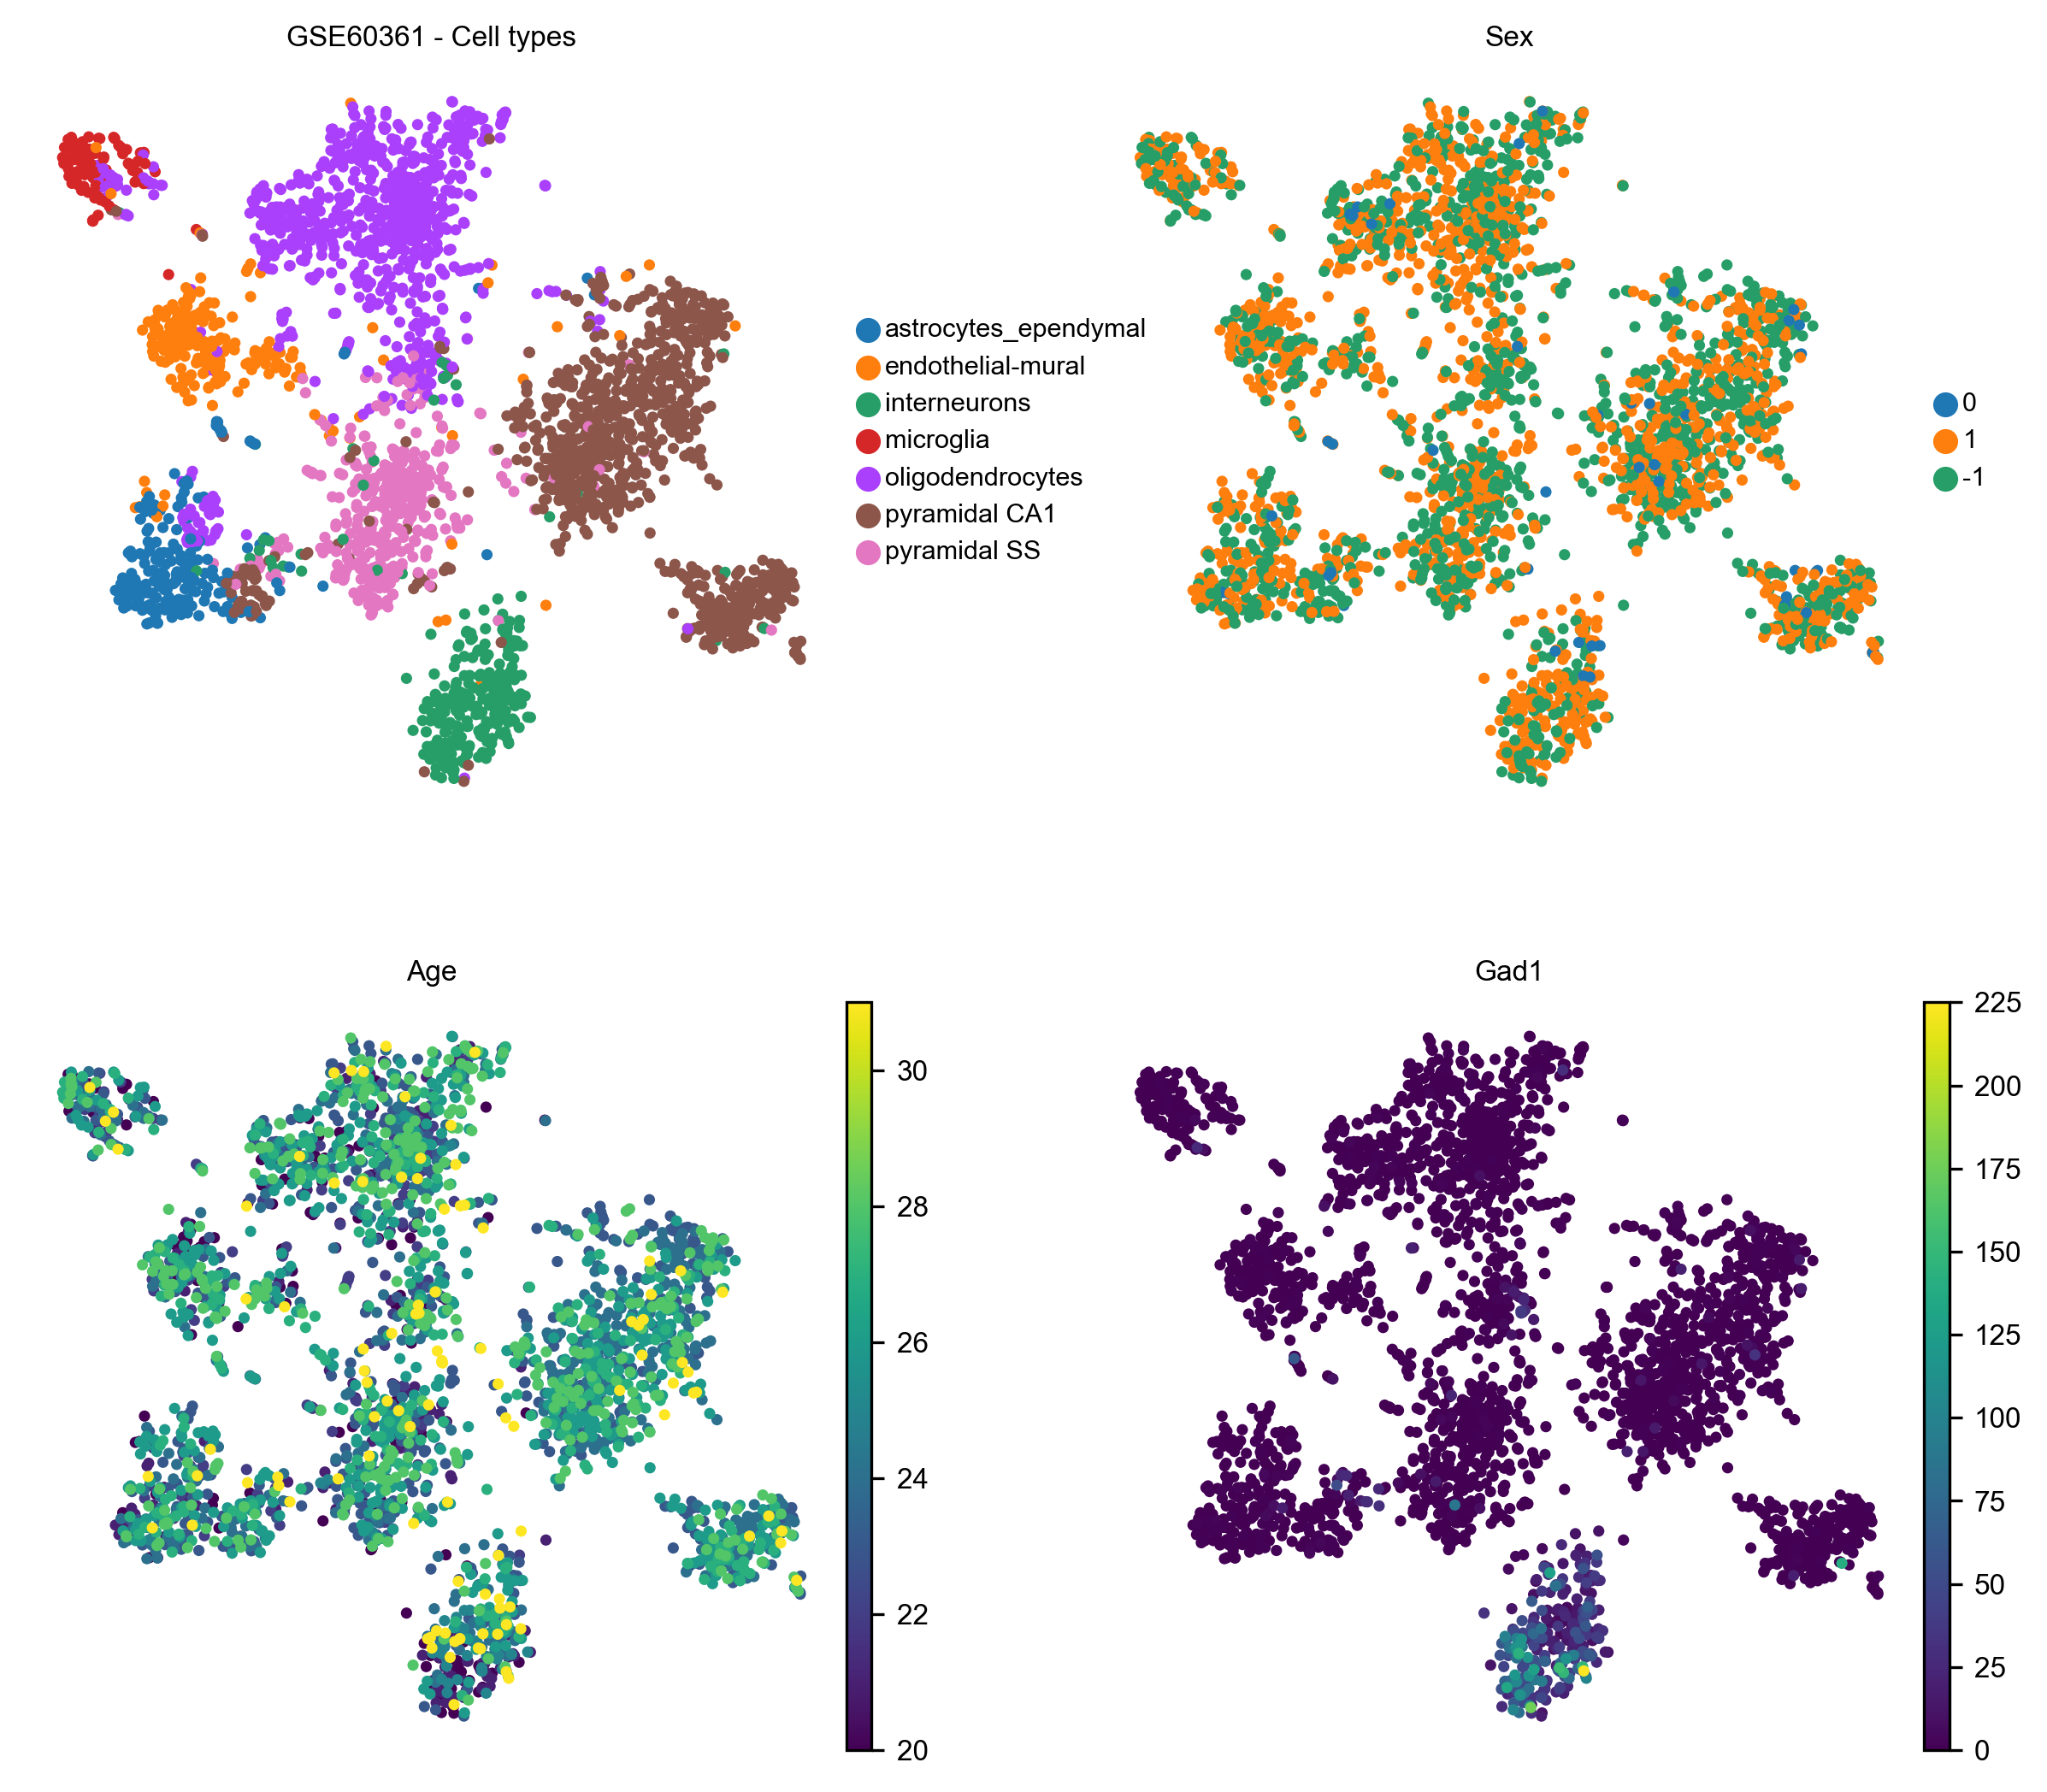

In [28]:
sc.set_figure_params(frameon=False, dpi=150, fontsize=8)
sc.pl.tsne(adata, color=['level1class', 'sex', 'age', 'Gad1'], 
           title=['GSE60361 - Cell types', 'Sex', 'Age', 'Gad1'], ncols=2)